# CPF Algorithmic Trading Practice Project
## Part 1 - Model Development and Backtest

### Full Name: Morten Rosenløv Jensen

#### Submission Date: 14-04-2025

======================================================================

**Project outline:**
- Use OANDA API for data retrieval and live trading.
- Instrument: 'EUR_USD'.
- Bar length for backtesting and live trading: 5 min.
- Backtesting period: 1 week.
- Live trading period: 6 hours.
- Use a classification model for prediction of the direction.

**Part 1 - Model development and backtest**
1. Import historical data from OANDA.
2. Add features.
3. Normalize, add lags and split into train/test sets.
4. Screen different classifier-models incl. ensemble and bagging models.
5. Optimize the best performing model.
6. Plotting model performance and save model for later use in live testing.

**Part 2 - Implementation and live testing**
- Not covered in this Notebook

### Imports

In [ ]:
# Package installation for Colab execution
!pip install --quiet git+https://github.com/yhilpisch/tpqoa.git
!pip install --quiet 

# Install TALib
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
!pip install conda-package-handling
!wget https://anaconda.org/conda-forge/ta-lib/0.5.1/download/linux-64/ta-lib-0.5.1-py311h9ecbd09_0.conda
!cph x ta-lib-0.5.1-py311h9ecbd09_0.conda
!mv ./ta-lib-0.5.1-py311h9ecbd09_0/lib/python3.11/site-packages/talib /usr/local/lib/python3.11/dist-packages/

In [1]:
import os
import tpqoa
import numpy as np
import pandas as pd
from pylab import plt
plt.style.use('seaborn-v0_8')
import mplfinance as fplt
import joblib
import talib
import matplotlib.dates as mdates
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import mutual_info_classif, SelectKBest, f_classif
from sklearn.pipeline import Pipeline


### 1. 1. Import historical data from OANDA

In [2]:
path = 'data'  # path to folder containing Oanda config-file
file = 'oanda.cfg' # name of Oanda config-file
config_file = os.path.join(path, file)

In [3]:
# Not used for Colab version where data have been retrieved
#api = tpqoa.tpqoa(config_file)  # create an API connection to Oanda

In [4]:
# Arguments for data import
symbol = 'EUR_USD'
start = '2025-04-06'
end = '2025-04-12'
granularity = 'M5'
prices = ['A', 'B', 'M']  # retrieve both bid and ask prices to calculate spread

In [5]:
raw = {}
for price in prices:
    file = f'{symbol}_{start}_{end}_{granularity}_{price}.csv'
    data_file = os.path.join(path, file)
    try:
        raw[price] = pd.read_csv(data_file, index_col=0, parse_dates=True)
        print('Retrieving data from disk')
    except:
        raw[price] = api.get_history(symbol, start, end, granularity, price)
        raw[price].to_csv(data_file)
        print('Retrieving data from OANDA')

Retrieving data from disk
Retrieving data from disk
Retrieving data from disk


In [6]:
# Use mid-prices for the model
data = raw['M'].copy()
del data['complete']
data.columns = ['open', 'high', 'low', 'close', 'volume']
data.head()

,open,high,low,close,volume
time,,,,,
2025-04-06 21:00:00,1.08926,1.08936,1.08926,1.08930,3
2025-04-06 21:05:00,1.08923,1.08957,1.08834,1.08846,133
2025-04-06 21:10:00,1.08846,1.08884,1.08814,1.08834,157
2025-04-06 21:15:00,1.08828,1.08900,1.08827,1.08898,160
2025-04-06 21:20:00,1.08898,1.08922,1.08845,1.08854,182


In [7]:
# Calculate the average spread
spread = (raw['A']['c'] - raw['B']['c']).mean()

In [8]:
# Calculate the average log-trading cost (tc)
tc = np.log(raw['A']['c'] / raw['B']['c']).mean()
tc

0.00016961774451893752

### 1.2. Add Features

In [9]:
data['r'] = np.log(data['close'] / data['close'].shift(1))
data['d'] = np.where(data['r'] > 0, 1, 0)

In [10]:
# Trend
data['SMA10'] = data['close'].rolling(10).mean()
data['SMA30'] = data['close'].rolling(30).mean()
data['ADX'] = talib.ADX(data['high'], data['low'], data['close'], timeperiod=14)
data['PLUS_DI'] = talib.PLUS_DI(data['high'], data['low'], data['close'], timeperiod=14)
data['MINUS_DI'] = talib.MINUS_DI(data['high'], data['low'], data['close'], timeperiod=14)

# Momentum
data['RSI_9'] = talib.RSI(data['close'], timeperiod=9)
macd, macdsignal, macdhist = talib.MACD(data['close'])
data['MACD'] = macd
data['MACD_signal'] = macdsignal
data['MACD_hist'] = macdhist


# Volatility
data['ATR'] = talib.ATR(data['high'], data['low'], data['close'], timeperiod=14)
data['VOL10'] = data['r'].rolling(10).mean()
data['VOL30'] = data['r'].rolling(30).mean()

# Slope
data['SMA10_SLOPE'] = np.arctan((data['SMA10'].shift(1)
                                 - data['SMA10'].shift(5)) / 4)
data['SMA30_SLOPE'] = np.arctan((data['SMA30'].shift(1)
                                 - data['SMA30'].shift(5)) / 4)
data['VOL10_SLPOE'] = np.arctan((data['VOL10'].shift(1)
                                 - data['VOL10'].shift(5)) / 4)
data['VOL30_SLPOE'] = np.arctan((data['VOL30'].shift(1)
                                 - data['VOL30'].shift(5)) / 4)

# Price - Action
data['CO'] = data['close'] / data['open'] - 1
data['OHLC4'] = (data['open'] + data['high']
                 + data['low'] + data['close']) / 4

# Calendar - cyclical (sin/cos) time of day
tod = data.index.hour + data.index.minute / 60
data['TOD_SIN'] = np.sin(2 * np.pi * tod  /24)
data['TOD_COS'] = np.cos(2 * np.pi * tod  /24)

In [11]:
# List of features
exclude = ['open', 'high', 'low', 'close', 'volume', 'd']
base_features = [x for x in data.columns if x not in exclude]
# Calendar features should not be lagged
no_lag_features = ['TOD_SIN', 'TOD_COS']

### 1.3. Normalize, add lags and split into train/test sets

In [12]:
split = 0.8  #use 80% for training, 20% for testing

In [13]:
split_index = int(len(data) * split)

In [14]:
train = data[base_features].iloc[:split_index].copy()
test = data[base_features].iloc[split_index:].copy()

In [15]:
scaler = StandardScaler()
scaler.fit_transform(train)
data_ = pd.DataFrame(scaler.transform(data[base_features]), 
                     index=data.index, columns=base_features)

In [16]:
# Add lags
lags = 10  # Number of lags
lag_features = []  # empty list for the lagged features columns
lagged_dfs = []
for feat in base_features:
    for lag in range(1, lags + 1):
        col_ = f'{feat}_lag{lag}'
        if feat not in no_lag_features:
            lag_features.append(col_)
            lagged_col = data_[feat].shift(lag).rename(col_)
            lagged_dfs.append(lagged_col)
            #data_[col_] = data_[feat].shift(lag)
            
        elif lag == 1:  # calendar features are only lagged once
            lag_features.append(col_)
            lagged_col = data_[feat].shift(lag).rename(col_)
            lagged_dfs.append(lagged_col)
            #data_[col_] = data_[feat].shift(lag)
lagged_df = pd.concat(lagged_dfs, axis=1)
data_ = pd.concat([data_, lagged_df], axis=1)
data_.dropna(inplace=True) 

In [17]:
# Create train/test splits based on normalized and lagged data
X_train = data_[lag_features].iloc[:split_index].copy()
y_train = data['d'].loc[X_train.index].copy()  # align to X_train index after dropna()
X_test = data_[lag_features].iloc[split_index:].copy()
y_test = data['d'].loc[X_test.index].copy() # align to X_test index after dropna()

In [18]:
# Verify that train/test X/y match
print(f'{"Train data have same starting point:".ljust(38)} {X_train.index[0] == y_train.index[0]}')
print(f'{"Train data have same end point:".ljust(38)} {X_train.index[-1] == y_train.index[-1]}')
print(f'{"Test data have same starting point:".ljust(38)} {X_test.index[0] == y_test.index[0]}')
print(f'{"Test data have same end point:".ljust(38)} {X_test.index[-1] == y_test.index[-1]}')

Train data have same starting point:   True
Train data have same end point:        True
Test data have same starting point:    True
Test data have same end point:         True


In [19]:
# Evaluate potential imbalance in the labels data
one = len(y_train.loc[y_train == 1]) / len(y_train)
zero = 1 - one
print(f'y_train zeros: {zero * 100:.2f}%')
print(f'y_train ones : {one * 100:.2f}%')

y_train zeros: 46.31%
y_train ones : 53.69%


**This means that a model can achieve an accuracy of 53.7%
just by always predicting '1'**

### 1.4. Screen different classifier-models

In [20]:
# Models 1 - 6:   Scikit-learn classifier models
# Model 7:        Scikit-learn neural network model
# Models 8 - 14:  BaggingClassifier models with different base-estimators
# Models 14 - 16: AbdBoostClassifier models with different base-estimators
models_1 = {
    'Model_1': LogisticRegression(max_iter=1000, random_state=100),
    'Model_2': GaussianNB(),
    'Model_3': KNeighborsClassifier(),
    'Model_4': DecisionTreeClassifier(random_state=100),
    'Model_5': RandomForestClassifier(random_state=100),
    'Model_6': SVC(random_state=100),
    'Model_7': MLPClassifier([128, 128], max_iter=2000, early_stopping=True, random_state=100),
    'Model_8': BaggingClassifier(estimator=LogisticRegression(max_iter=1000, random_state=100),
                                 random_state=100,
                                 n_estimators=10),
    'Model_9': BaggingClassifier(estimator=GaussianNB(),
                                 random_state=100,
                                 n_estimators=10),
    'Model_10': BaggingClassifier(estimator=KNeighborsClassifier(),
                                 random_state=100,
                                 n_estimators=10),
    'Model_11': BaggingClassifier(estimator=DecisionTreeClassifier(random_state=100),
                                 random_state=100,
                                 n_estimators=10),
    'Model_12': BaggingClassifier(estimator=RandomForestClassifier(random_state=100),
                                 random_state=100,
                                 n_estimators=10),
    'Model_13': BaggingClassifier(estimator=SVC(random_state=100),
                                 random_state=100,
                                 n_estimators=10),
    'Model_14': BaggingClassifier(estimator=MLPClassifier(
        [128, 128], max_iter=2000, early_stopping=True, random_state=100),
                                 random_state=100,
                                 n_estimators=10),
    'Model_15': AdaBoostClassifier(estimator=LogisticRegression(max_iter=1000, random_state=100),
                                 random_state=100,
                                 n_estimators=10),
    'Model_16': AdaBoostClassifier(estimator=DecisionTreeClassifier(random_state=100),
                                 random_state=100,
                                 n_estimators=10)         }

In [21]:
for model in models_1:
    class_model = models_1.get(model)
    name = model
    class_model.fit(X_train, y_train)  
    y_pred = class_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f'Accuracy score for {name.ljust(10)} | Accuracy score: {acc:.4f}')

Accuracy score for Model_1    | Accuracy score: 0.5679
Accuracy score for Model_2    | Accuracy score: 0.5267
Accuracy score for Model_3    | Accuracy score: 0.5679
Accuracy score for Model_4    | Accuracy score: 0.4979
Accuracy score for Model_5    | Accuracy score: 0.5062
Accuracy score for Model_6    | Accuracy score: 0.5309
Accuracy score for Model_7    | Accuracy score: 0.5556
Accuracy score for Model_8    | Accuracy score: 0.5638
Accuracy score for Model_9    | Accuracy score: 0.5473
Accuracy score for Model_10   | Accuracy score: 0.5226
Accuracy score for Model_11   | Accuracy score: 0.5062
Accuracy score for Model_12   | Accuracy score: 0.4938
Accuracy score for Model_13   | Accuracy score: 0.5103
Accuracy score for Model_14   | Accuracy score: 0.5144
Accuracy score for Model_15   | Accuracy score: 0.5556
Accuracy score for Model_16   | Accuracy score: 0.5103


### <u>Part Conclusion:<u>
- Best accuracies are achieved for models 1, 3, 7, 8 and 15.
- But do they also give the best strategy returns?

**Evaluate strategy returns with/without trading cost**

In [22]:
# Helper function for model fit, predict and calculation of performance
def calculate_performance(model, models, X_train, y_train, X_test, y_test):
    class_model = models.get(model)
    name = model
    class_model.fit(X_train, y_train)  
    results = data['r'].loc[X_test.index].copy().to_frame()  # initialize a results dataframe
    results['pred'] = class_model.predict(X_test)
    results['pos'] = np.where(results['pred'] > 0.5, 1, -1)  # long/short position    
    results['s'] = results['pos'] * results['r']  # strategy returns
    # Strategy returns adjusted for trading cost
    results['s_tc'] = np.where(results['pos'].diff() != 0, results['s'] - tc, results['s'])
    strategy = np.exp(results['s'].sum())
    strategy_tc = np.exp(results['s_tc'].sum())
    trades = sum(results['pos'].diff() != 0)
    acc = accuracy_score(results['pred'], y_test)
    print(f'Returns for {name.ljust(10)} | Strategy: {strategy:.4f} \
| Strategy incl. tc: {strategy_tc:.4f} | Acc: {acc:.4f} | #trades: {trades}')
    return results

In [23]:
# Calculate strategy returns for all models
results = data['r'].loc[X_test.index].copy().to_frame()  # initialize a results dataframe
base = np.exp(results['r'].sum())
print(98*'=')
print(f'Buy-and-hold returns: {base:.4f}')
print(98*'=')
for model in models_1:
    calculate_performance(model, models_1, X_train, y_train, X_test, y_test)

Buy-and-hold returns: 1.0040
Returns for Model_1    | Strategy: 1.0119 | Strategy incl. tc: 1.0027 | Acc: 0.5679 | #trades: 54
Returns for Model_2    | Strategy: 1.0002 | Strategy incl. tc: 0.9982 | Acc: 0.5267 | #trades: 12
Returns for Model_3    | Strategy: 1.0262 | Strategy incl. tc: 1.0145 | Acc: 0.5679 | #trades: 68
Returns for Model_4    | Strategy: 0.9978 | Strategy incl. tc: 0.9813 | Acc: 0.4979 | #trades: 98
Returns for Model_5    | Strategy: 0.9913 | Strategy incl. tc: 0.9802 | Acc: 0.5062 | #trades: 66
Returns for Model_6    | Strategy: 1.0062 | Strategy incl. tc: 1.0014 | Acc: 0.5309 | #trades: 28
Returns for Model_7    | Strategy: 1.0064 | Strategy incl. tc: 1.0040 | Acc: 0.5556 | #trades: 14
Returns for Model_8    | Strategy: 1.0083 | Strategy incl. tc: 0.9991 | Acc: 0.5638 | #trades: 54
Returns for Model_9    | Strategy: 1.0188 | Strategy incl. tc: 1.0157 | Acc: 0.5473 | #trades: 18
Returns for Model_10   | Strategy: 1.0023 | Strategy incl. tc: 0.9905 | Acc: 0.5226 | #tr

### <u>Part Conclusion:<u>
- Several models outperform the pasive banchmark (buy-and-hold).
- However when including trading cost, only three models (slightly) outperform the baseline.
- Best model incl. trading cost is Model_9: `BaggingClassifier(estimator=GaussianNB())`.
- Model 3: `KNeighborsClassifier()` has a fair performance and more trades, i.e. more 'action' during live test.
- From here-on we will evaluate optimizations on model 3: `KNeighborsClassifier()`.

### 1.5. Optimize the best performing model

#### 1.5.a. Optimize model hyper-parameters

In [24]:
knn_model = KNeighborsClassifier()

param_dist = {
    'n_neighbors': [3, 5, 7, 11, 15, 21],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'p': [1, 2]  # only relevant for metric='minkowski'
}

random_search = RandomizedSearchCV(
    estimator=knn_model,
    param_distributions=param_dist,
    n_iter=20,
    scoring='accuracy',
    n_jobs=-1,
    cv=TimeSeriesSplit(n_splits=5),
    verbose=1,
    random_state=100
)

random_search.fit(X_train, y_train)

print(f"Best parameters: {random_search.best_params_}")
print(f"Best score: {random_search.best_score_:.4f}")


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'weights': 'distance', 'p': 1, 'n_neighbors': 11, 'metric': 'minkowski'}
Best score: 0.5183


- The optimized results are equal to the default values except for max_features

In [25]:
# Based on this hyper-parameter optimization we fix the model and calculate performance
models_2 = {
    'Baseline': KNeighborsClassifier(),
    'Optimized': KNeighborsClassifier(weights='distance',
                                     p=1,
                                     n_neighbors=11,
                                     metric='minkowski')
}
print(98*'=')
print(f'Buy-and-hold returns: {base:.4f}')
print(98*'=')
for model in models_2:
    results = calculate_performance(model, models_2, X_train, y_train, X_test, y_test)

Buy-and-hold returns: 1.0040
Returns for Baseline   | Strategy: 1.0262 | Strategy incl. tc: 1.0145 | Acc: 0.5679 | #trades: 68
Returns for Optimized  | Strategy: 1.0037 | Strategy incl. tc: 0.9957 | Acc: 0.5267 | #trades: 47


### <u>Part Conclusion:<u>
- Optimization attempts for better hyper-parameters did not improve the out-of-sample returns.

#### 1.5.a. Optimize data features (for baseline model only)
- Evaluate if model performance improves when picking a smaller number of the best features.
- Method: `SelectKBest`

In [26]:
# Number of features
len(lag_features)

192

In [27]:
# Evaluete performance for different fractions of the total features list
fractions = np.arange(0.2, 1.1, 0.1).round(1) # percentage of features we want to retain
features_list = {} # dictionary for the best features

for fraction in fractions:
    models_3 = {'Baseline': KNeighborsClassifier()}
    model = 'Baseline'
    top_k = int(len(lag_features) * fraction)

    selector = SelectKBest(f_classif, k=top_k)
    best = selector.fit(X_train, y_train).get_support(indices=True)
    selected_features = X_train.columns[best]
    features_list[fraction] = selected_features
    X_train_best = data_[selected_features].iloc[:split_index].copy()
    X_test_best = data_[selected_features].iloc[split_index:].copy()

    print(95*'=')
    print(f'Fraction: {fraction} | Results:')
    print(95*'=')
    results = calculate_performance(model, models_3, X_train_best, y_train, X_test_best, y_test)

Fraction: 0.2 | Results:
Returns for Baseline   | Strategy: 1.0047 | Strategy incl. tc: 0.9919 | Acc: 0.5021 | #trades: 76
Fraction: 0.3 | Results:
Returns for Baseline   | Strategy: 1.0025 | Strategy incl. tc: 0.9903 | Acc: 0.4979 | #trades: 72
Fraction: 0.4 | Results:
Returns for Baseline   | Strategy: 1.0170 | Strategy incl. tc: 1.0036 | Acc: 0.5144 | #trades: 78
Fraction: 0.5 | Results:
Returns for Baseline   | Strategy: 1.0150 | Strategy incl. tc: 1.0007 | Acc: 0.5185 | #trades: 84
Fraction: 0.6 | Results:
Returns for Baseline   | Strategy: 1.0113 | Strategy incl. tc: 0.9976 | Acc: 0.5144 | #trades: 80
Fraction: 0.7 | Results:
Returns for Baseline   | Strategy: 0.9942 | Strategy incl. tc: 0.9813 | Acc: 0.5267 | #trades: 77
Fraction: 0.8 | Results:
Returns for Baseline   | Strategy: 1.0357 | Strategy incl. tc: 1.0228 | Acc: 0.5926 | #trades: 74
Fraction: 0.9 | Results:
Returns for Baseline   | Strategy: 1.0243 | Strategy incl. tc: 1.0118 | Acc: 0.5679 | #trades: 72
Fraction: 1.0 | 

#### <u>Part Conclusion:<u>
- Improved model accuracy and returns when selecting the best 80% features.
- We save the list of features and use it with the model going forward

In [28]:
selected_features = features_list[0.8]  # picking the best result
X_train_best = data_[selected_features].iloc[:split_index].copy()
X_test_best = data_[selected_features].iloc[split_index:].copy()
print(95*'=')
print(f'Fraction: {fraction} | Results:')
print(95*'=')
results = calculate_performance(model, models_3, X_train_best, y_train, X_test_best, y_test)

Fraction: 1.0 | Results:
Returns for Baseline   | Strategy: 1.0357 | Strategy incl. tc: 1.0228 | Acc: 0.5926 | #trades: 74


### 1.6. Plotting model performance and save model for later use in live testing

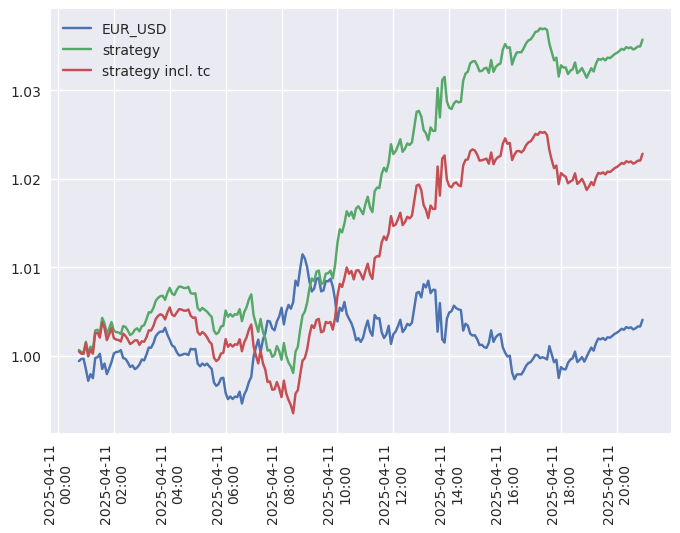

In [29]:
# Plotting the returns
plt.plot(fig_size=(10, 6))
plt.plot(results[['r', 's', 's_tc']].dropna().cumsum().apply(np.exp), 
         label=[symbol, 'strategy', 'strategy incl. tc'])
plt.xticks(rotation=90)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d\n%H:%M'))
plt.legend();

In [30]:
# Create candle stick chart with long/short trade positions
trades = results['pos'].copy().to_frame()
trades['trade'] = np.where(trades['pos'].diff() != 0, 1, np.nan)
trades['long'] = np.where((trades['trade']==1) & (trades['pos']==1), 1, np.nan)
trades['short'] = np.where((trades['trade']==1) & (trades['pos']==-1), 1, np.nan)
# for better location of chart:
trades['long'] = trades['long'] * data.loc[X_test.index]['low'] - 0.002
trades['short'] = trades['short'] * data.loc[X_test.index]['high'] + 0.002

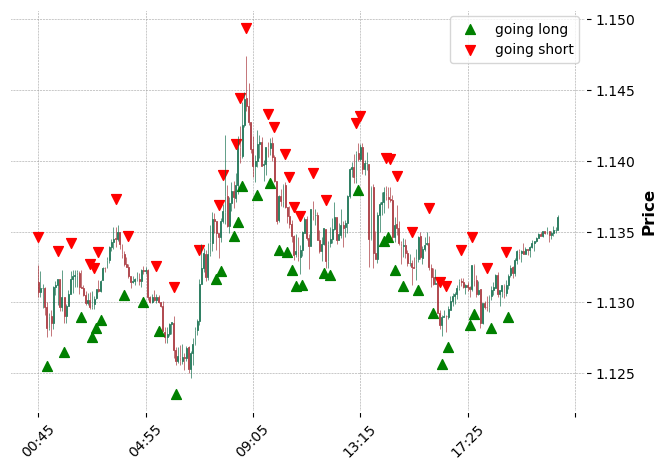

In [31]:
adp_1 = fplt.make_addplot(trades['long'], type='scatter',
                        markersize=50, marker='^', color='green', label='going long')
adp_2 = fplt.make_addplot(trades['short'], type='scatter',
                        markersize=50, marker='v', color='red', label='going short')
fplt.plot(data.loc[X_test.index], type='candle', style='charles', addplot=[adp_1, adp_2])

**Create and save a `joblib` file for live test implementation in Step 2.**

In [32]:
model = KNeighborsClassifier()
model.fit(X_train_best, y_train)
# just for verificetion, we print the acuracy_score to check it is correct
acc = accuracy_score(model.predict(X_test_best), y_test)
print(acc)

# Save pipeline for later live-testing implementation
joblib.dump({'scaler': scaler,
             'model': model,
            'features': selected_features.tolist()},
            'knn_bundle.joblib')

0.5925925925925926


['knn_bundle.joblib']

## <u>Conclusion:<u>
- A screening of 16 different models indicated that `KNeighborsClassifier` performs well and has a fair amount of trades.
- However, must models struggle to out-perform the buy-and-hold baseline when including trading cost.
- Attempts to optimize hyper-parameters did not improve the results further.
- Attempts to reduce the number of features gave improved results at 80% of the features.
- Note: the train/test data sets are small to increase calculation speed.
=> The model may not perform well going forward.